## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import export_blockvisibility_to_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client



In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc-smodel.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
nfreqwin = 1
ntimes = 61
rmax = 10000.0
dec = -40.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(
    lowcore,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [5]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']
if npixel > 1024:
    deconvolve_facets = 8
    deconvolve_overlap = 32
    deconvolve_taper = 'tukey'
else:
    deconvolve_facets = 1
    deconvolve_overlap = 0
    deconvolve_taper = 'tukey'

### Generate the model from the GLEAM catalog, including application of the primary beam.

In [6]:
flux_limit=0.2
dft_threshold = 10.0
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

all_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)

all_components = filter_skycomponents_by_flux(all_components, flux_min=flux_limit)

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '4.883434121124295'
		min: '0.0'
		rms: '0.014243987727979864'
		sum: '5649.720590114917'
		medianabs: '0.0'
		median: '0.0'



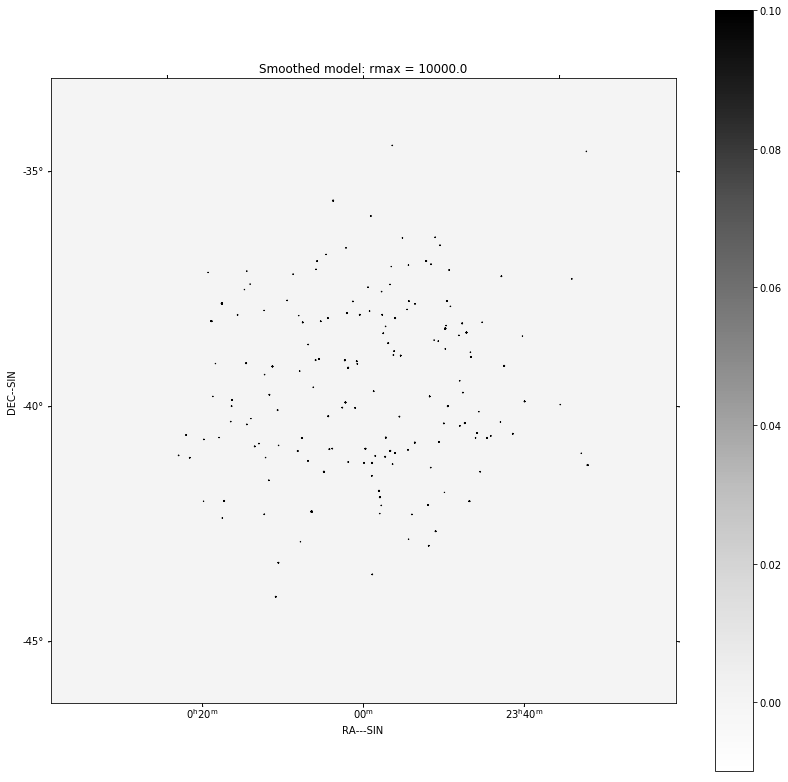

In [7]:
smodel = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
smodel = insert_skycomponent(smodel, all_components)
smodel = smooth_image(smodel, 3.0)
lprint(qa_image(smodel))
show_image(
    smodel,
    cm='Greys',
    title='Smoothed model: rmax = %.1f' % rmax,
    vmax=0.1, vmin=-0.01)

export_image_to_fits(smodel,
                     'results/low-sims-smodel_rmax%.1f.fits' % rmax)
plt.savefig('figures/low-sims-smodel_rmax%.1f.png' % rmax)
plt.show()